In [1]:
%pip install pandas numpy matplotlib seaborn jinja2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

Note: you may need to restart the kernel to use updated packages.


Datasets loaded successfully.
Data cleaning complete.
Master dataframe created with price floors and targets.
Pricing recommendations generated and saved.


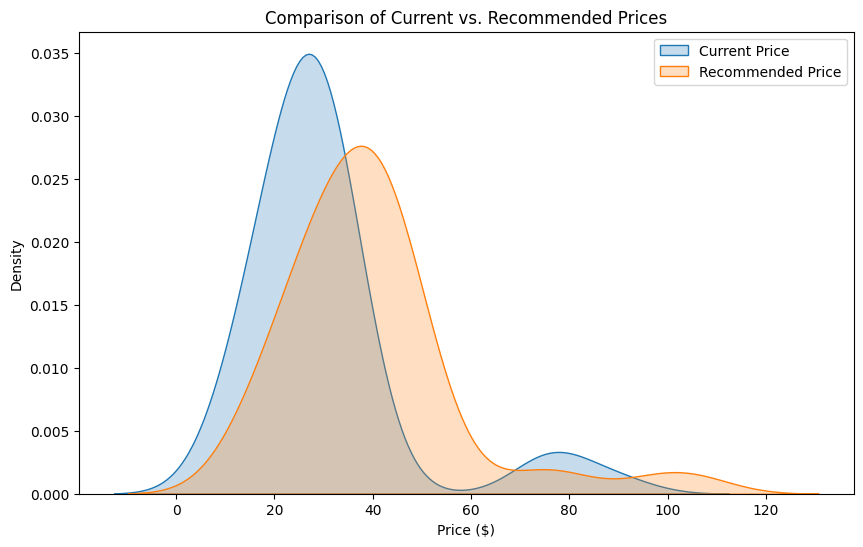

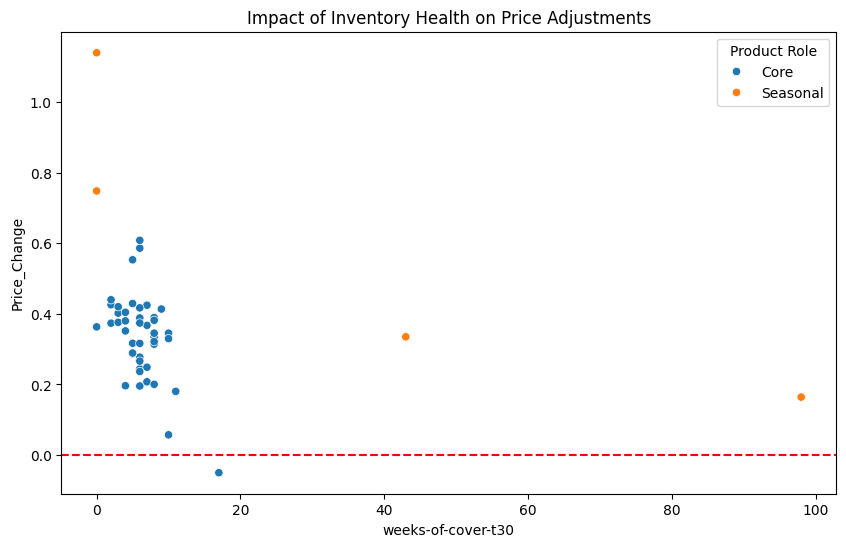

In [2]:
# To clean currency and percentage strings as the data definition
def clean_numeric(val):
    if pd.isna(val) or val == '-':
        return np.nan
    if isinstance(val, str):
        val = val.replace('$', '').replace('%', '').replace(',', '').strip()
        try:
            return float(val)
        except ValueError:
            return np.nan
    return val

pricing_df = pd.read_csv('Pricing_Data.csv')
comp_df = pd.read_csv('Competitor_Data.csv')
sales_df = pd.read_csv('Historical_Sales.csv')
inv_df = pd.read_csv('Inventory_Health.csv')
ads_df = pd.read_csv('Ads_Performance.csv')
returns_df = pd.read_csv('Returns_Data.csv')

print("Datasets loaded successfully.")

pricing_cols = ['FBA Fee', 'Storage Fee', 'Handling_Cost', 'Cost', 'Current_Price', 'Minimum_Acceptable_Margin_%', 'Target_Gross_Margin_%']
for col in pricing_cols:
    pricing_df[col] = pricing_df[col].apply(clean_numeric)

pricing_df['Minimum_Acceptable_Margin_%'] /= 100
pricing_df['Target_Gross_Margin_%'] /= 100

comp_cols = ['Avg_Competitor_Price', 'Lowest_Competitor_Price', 'Highest_Competitor_Price']
for col in comp_cols:
    comp_df[col] = comp_df[col].apply(clean_numeric)

returns_df.columns = ['SKU', 'returns_7d', 'returns_30d', 'returns_60d', 'returns_90d']
returns_df['returns_7d'] = returns_df['returns_7d'].apply(clean_numeric)

print("Data cleaning complete.")

sales_agg = sales_df.groupby('SKU')['Units Ordered'].sum().reset_index()
ads_agg = ads_df.groupby('SKU').agg({'spend': 'sum', 'sales14d': 'sum'}).reset_index()

df = pricing_df.merge(inv_df, on='SKU', how='left') \
               .merge(comp_df, on='SKU', how='left') \
               .merge(sales_agg, on='SKU', how='left') \
               .merge(ads_agg, on='SKU', how='left') \
               .merge(returns_df, on='SKU', how='left')

df['total_cost'] = df['Cost'] + df['FBA Fee'] + df['Storage Fee'] + df.get('Handling_Cost', 0).fillna(0)
df['price_floor'] = df['total_cost'] / (1 - df['Minimum_Acceptable_Margin_%'])
df['target_price'] = df['total_cost'] / (1 - df['Target_Gross_Margin_%'])

print("Master dataframe created with price floors and targets.")

def apply_pricing_strategy(row):
    # Retrieves the key signals 
    floor = row['price_floor']
    target = row['target_price']
    comp_avg = row['Avg_Competitor_Price'] if pd.notna(row['Avg_Competitor_Price']) else row['Current_Price']
    woc = row['weeks-of-cover-t30'] 
    if woc > 12:
        recommended = min(comp_avg, row['Current_Price'] * 0.95)
        reason = "Overstock Strategy"
    elif woc < 4 and woc > 0:
        recommended = max(target, row['Highest_Competitor_Price'] if pd.notna(row['Highest_Competitor_Price']) else target)
        reason = "Stock Pressure Management"
    else:
        recommended = max(target, comp_avg)
        reason = "Market/Margin Alignment"
    if recommended < floor:
        recommended = floor
        reason += " (Floor Applied)"
        
    return round(recommended, 2), reason
results = df.apply(apply_pricing_strategy, axis=1)
df['Recommended_Price'], df['Logic_Reason'] = zip(*results)

df[['SKU', 'Product Role', 'Current_Price', 'Recommended_Price', 'Logic_Reason']].to_csv('Final_Pricing_Recommendations.csv', index=False)
print("Pricing recommendations generated and saved.")
plt.figure(figsize=(10, 6))
sns.kdeplot(df['Current_Price'], label='Current Price', fill=True)
sns.kdeplot(df['Recommended_Price'], label='Recommended Price', fill=True)
plt.title('Comparison of Current vs. Recommended Prices')
plt.xlabel('Price ($)')
plt.legend()
plt.show()
df['Price_Change'] = (df['Recommended_Price'] - df['Current_Price']) / df['Current_Price']
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='weeks-of-cover-t30', y='Price_Change', hue='Product Role')
plt.axhline(0, color='red', linestyle='--')
plt.title('Impact of Inventory Health on Price Adjustments')
plt.show()

In [3]:
# Category Level Summary Table
summary_by_role = df.groupby('Product Role').agg({
    'SKU': 'count',
    'Current_Price': 'mean',
    'Recommended_Price': 'mean',
    'weeks-of-cover-t30': 'mean'
}).rename(columns={'SKU': 'SKU Count', 'weeks-of-cover-t30': 'Avg Weeks of Cover'})
summary_by_role['Avg Price Change (%)'] = ((summary_by_role['Recommended_Price'] - summary_by_role['Current_Price']) / summary_by_role['Current_Price']) * 100
print("--- Executive Summary by Product Role ---")
display(summary_by_role.round(2))
cols_to_show = ['SKU', 'Product Role', 'Current_Price', 'Recommended_Price', 'Price_Change', 'weeks-of-cover-t30', 'Logic_Reason']
recommendations_preview = df[cols_to_show].head(10)
print("\n--- Top 10 Recommended SKU Adjustments ---")
try:
    display(recommendations_preview.style.format({
        'Current_Price': '{:.2f}',
        'Recommended_Price': '{:.2f}',
        'Price_Change': '{:.1%}'
    }).background_gradient(subset=['Price_Change'], cmap='RdYlGn'))
except Exception as e:
    print("(Note: Styling engine not found, displaying raw table)")
    display(recommendations_preview)

--- Executive Summary by Product Role ---


,SKU Count,Current_Price,Recommended_Price,Avg Weeks of Cover,Avg Price Change (%)
Product Role,,,,,
Core,46,30.94,40.18,6.26,29.84
Seasonal,4,20.41,31.92,35.25,56.37



--- Top 10 Recommended SKU Adjustments ---


,SKU,Product Role,Current_Price,Recommended_Price,Price_Change,weeks-of-cover-t30,Logic_Reason
0,MN-01,Core,38.90,49.69,27.7%,6,Market/Margin Alignment
1,MN-02,Core,33.90,40.92,20.7%,7,Market/Margin Alignment
2,MN-03,Core,34.90,46.20,32.4%,8,Market/Margin Alignment
3,MN-04,Core,29.90,39.91,33.5%,8,Market/Margin Alignment
4,MN-05,Seasonal,21.90,46.85,113.9%,0,Market/Margin Alignment
5,MN-06,Seasonal,14.95,26.13,74.8%,0,Market/Margin Alignment
6,MN-07,Core,34.90,45.95,31.7%,5,Market/Margin Alignment
7,MN-08,Seasonal,29.90,34.81,16.4%,98,Overstock Strategy (Floor Applied)
8,MN-09,Seasonal,14.90,19.89,33.5%,43,Overstock Strategy (Floor Applied)
9,MN-10,Core,19.90,26.77,34.5%,10,Market/Margin Alignment


In [4]:
def get_advanced_reason(row):
    reasons = []
    if row['weeks-of-cover-t30'] < 4:
        reasons.append("Inventory: Stock Pressure Protection")
    elif row['weeks-of-cover-t30'] > 12:
        reasons.append("Inventory: Overstock Liquidation")
    if row['Recommended_Price'] == row['price_floor']:
        reasons.append("Margin: Floor Guardrail Applied")
    elif row['Recommended_Price'] > row['target_price']:
        reasons.append("Profitability: Captured Target Margin")
    if row['Recommended_Price'] <= row['Lowest_Competitor_Price']:
        reasons.append("Market: Competitive Match")
    if row.get('acosClicks7d', 0) > 0.30:
        reasons.append("Ads: High ACOS Buffer Included")
    return " | ".join(reasons) if reasons else "Standard Market Alignment"
df['Logic_Reason_Detailed'] = df.apply(get_advanced_reason, axis=1)

In [5]:
if 'Price_Change' not in df.columns:
    df['Price_Change'] = (df['Recommended_Price'] - df['Current_Price']) / df['Current_Price']

def get_logic_reason(row):
    if row['weeks-of-cover-t30'] > 12:
        return "Overstock: Price reduction for sell-through"
    elif row['weeks-of-cover-t30'] < 4:
        return "Stock Pressure: Increase to protect inventory"
    elif row['Recommended_Price'] <= row['price_floor']:
        return "Margin Guardrail: Minimum margin applied"
    else:
        return "Market Align: Target margin achieved"

df['Logic_Reason'] = df.apply(get_logic_reason, axis=1)
summary_by_role = df.groupby('Product Role').agg({
    'SKU': 'count',
    'Current_Price': 'mean',
    'Recommended_Price': 'mean',
    'weeks-of-cover-t30': 'mean'
}).rename(columns={'SKU': 'SKU Count', 'weeks-of-cover-t30': 'Avg Weeks of Cover'})
summary_by_role['Avg Price Change (%)'] = ((summary_by_role['Recommended_Price'] - summary_by_role['Current_Price']) / summary_by_role['Current_Price']) * 100
print("--- Executive Summary by Product Role ---")
display(summary_by_role.round(2))
cols_to_show = ['SKU', 'Product Role', 'Current_Price', 'Recommended_Price', 'Price_Change', 'weeks-of-cover-t30', 'Logic_Reason']
recommendations_preview = df[cols_to_show].head(10)
print("\n--- Top 10 Recommended SKU Adjustments ---")
try:
    display(recommendations_preview.style.format({
        'Current_Price': '${:.2f}',
        'Recommended_Price': '${:.2f}',
        'Price_Change': '{:.1%}'
    }).background_gradient(subset=['Price_Change'], cmap='RdYlGn'))
except Exception as e:
    print("(Note: Styling engine not found, displaying raw table)")
    display(recommendations_preview)

--- Executive Summary by Product Role ---


,SKU Count,Current_Price,Recommended_Price,Avg Weeks of Cover,Avg Price Change (%)
Product Role,,,,,
Core,46,30.94,40.18,6.26,29.84
Seasonal,4,20.41,31.92,35.25,56.37



--- Top 10 Recommended SKU Adjustments ---


,SKU,Product Role,Current_Price,Recommended_Price,Price_Change,weeks-of-cover-t30,Logic_Reason
0,MN-01,Core,$38.90,$49.69,27.7%,6,Market Align: Target margin achieved
1,MN-02,Core,$33.90,$40.92,20.7%,7,Market Align: Target margin achieved
2,MN-03,Core,$34.90,$46.20,32.4%,8,Market Align: Target margin achieved
3,MN-04,Core,$29.90,$39.91,33.5%,8,Market Align: Target margin achieved
4,MN-05,Seasonal,$21.90,$46.85,113.9%,0,Stock Pressure: Increase to protect inventory
5,MN-06,Seasonal,$14.95,$26.13,74.8%,0,Stock Pressure: Increase to protect inventory
6,MN-07,Core,$34.90,$45.95,31.7%,5,Market Align: Target margin achieved
7,MN-08,Seasonal,$29.90,$34.81,16.4%,98,Overstock: Price reduction for sell-through
8,MN-09,Seasonal,$14.90,$19.89,33.5%,43,Overstock: Price reduction for sell-through
9,MN-10,Core,$19.90,$26.77,34.5%,10,Market Align: Target margin achieved


--- ADVANCED FINANCIAL SUMMARY ---
Total Projected Profit Lift: $404,887.28
Average Allowable Conversion Drop: 71.01%


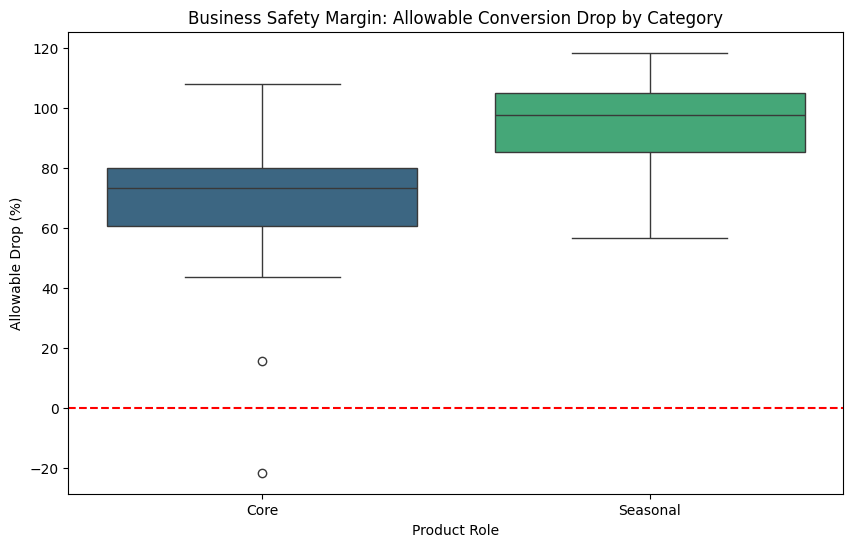

In [6]:
# DATA PREPARATION Ensuring all of the columns does exist and are numeric
cols_to_fix = ['Cost', 'FBA Fee', 'Storage Fee', 'Handling_Cost', 'Current_Price', 'Recommended_Price']
for col in cols_to_fix:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace('$', '').str.replace(',', ''), errors='coerce')
df['variable_cost'] = df['Cost'] + df['FBA Fee'] + df['Storage Fee'] + df['Handling_Cost'].fillna(0)
df['current_unit_margin'] = df['Current_Price'] - df['variable_cost']
df['recommended_unit_margin'] = df['Recommended_Price'] - df['variable_cost']
df['current_total_profit'] = df['current_unit_margin'] * df['Units Ordered'].fillna(0)
df['projected_total_profit'] = df['recommended_unit_margin'] * df['Units Ordered'].fillna(0)
df['allowable_conversion_drop_pct'] = (1 - (df['current_unit_margin'] / df['recommended_unit_margin'].replace(0, np.nan))) * 100
df['return_rate_pct'] = (df['returns_90d'] / df['units-shipped-t90'].replace(0, np.nan)) * 100

print("--- ADVANCED FINANCIAL SUMMARY ---")
print(f"Total Projected Profit Lift: ${(df['projected_total_profit'].sum() - df['current_total_profit'].sum()):,.2f}")
print(f"Average Allowable Conversion Drop: {df['allowable_conversion_drop_pct'].mean():.2f}%")

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Product Role', y='allowable_conversion_drop_pct', hue='Product Role', palette='viridis', legend=False)
plt.axhline(0, color='red', linestyle='--')
plt.title('Business Safety Margin: Allowable Conversion Drop by Category')
plt.ylabel('Allowable Drop (%)')
plt.show()

In [7]:
# Defining the three different management scenarios
scenarios = [
    {'name': 'Aggressive Growth', 'margin': 0.25, 'stock_threshold': 2},
    {'name': 'Balanced Stability', 'margin': 0.35, 'stock_threshold': 4},
    {'name': 'Profit Maximization', 'margin': 0.45, 'stock_threshold': 6}
]
scenario_results = []
for s in scenarios:
    temp_price = df.apply(
        lambda x: max(x['variable_cost'] / (1 - s['margin']), x['price_floor']) 
        if x['weeks-of-cover-t30'] >= s['stock_threshold'] 
        else x['Recommended_Price'] * 1.05, axis=1
    )
    total_profit = ((temp_price - df['variable_cost']) * df['Units Ordered']).sum()
    avg_price = temp_price.mean()
    scenario_results.append({
        'Scenario': s['name'],
        'Target Margin': f"{s['margin']:.0%}",
        'Stock Threshold': f"{s['stock_threshold']} wks",
        'Avg Recommended Price': f"${avg_price:.2f}",
        'Projected Total Profit': f"${total_profit:,.2f}"
    })

scenario_df = pd.DataFrame(scenario_results)
print("--- STRATEGIC SCENARIO COMPARISON (BONUS ARTIFACT) ---")
print(scenario_df.to_string(index=False))

--- STRATEGIC SCENARIO COMPARISON (BONUS ARTIFACT) ---
           Scenario Target Margin Stock Threshold Avg Recommended Price Projected Total Profit
  Aggressive Growth           25%           2 wks                $34.97            $372,573.12
 Balanced Stability           35%           4 wks                $40.28            $612,301.81
Profit Maximization           45%           6 wks                $45.37            $796,418.72
